In [1]:
from __future__ import print_function

# We'll need numpy for some mathematical operations
import numpy as np


# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
import timeit

from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()
    

/Users/kayote/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#audio_path = librosa.util.example_audio_file()
audio_path = 'first_test2.aiff'

y, sr = librosa.load(audio_path)

In [3]:
data = pd.read_csv('first_test2.txt', names=['ts', 'bank', 'pitch', 'vel'],sep=' ')
chirp_ts = data.ts[data.bank=='start'].iloc[0]
print(chirp_ts)
chirp_ind = np.min(np.where(y>0.1))
print(chirp_ind)
data.head()

1.48661117593e+12
413903


,ts,bank,pitch,vel
0,1.486611e+12,start,NaN,NaN
1,1.486611e+12,0,1.0,32.0
2,1.486611e+12,0,1.0,0.0
3,1.486611e+12,0,2.0,32.0
4,1.486611e+12,0,2.0,0.0


In [4]:
def get_sample(y,ts1,ts2,sr,chirp_ts,chirp_ind):
    ind1 = int(chirp_ind+(ts1+150-chirp_ts)*sr/1000.0)
    ind2 = int(chirp_ind+(ts2-150-chirp_ts)*sr/1000.0)
    return y[ind1:ind2]

def get_sample_by_meta(y,data,bank,pitch,vel,sr,chirp_ts,chirp_ind):
    ts1 = data.ts[(data.pitch==pitch) & (data.bank==bank) & (data.vel==vel)].iloc[0]
    ts2 = data.ts[np.where((data.pitch==pitch) & (data.bank==bank) & (data.vel==vel))[0]+1].iloc[0]
    ind1 = int(chirp_ind+(ts1+150-chirp_ts)*sr/1000.0)
    ind2 = int(chirp_ind+(ts2-150-chirp_ts)*sr/1000.0)
    return y[ind1:ind2]    

In [5]:
print(np.array(0))
first_dict = {'bank':data.bank[0],'pitch':data.pitch[0],'vel':data.vel[9],'sample':[[]]}
print(first_dict)
samples = pd.DataFrame(first_dict,index=[0])
print(samples)
for pitch in np.unique(data.pitch):
    for vel in np.setdiff1d(np.unique(data.vel),0):
        for bank in np.setdiff1d(np.unique(data.bank),'start'):
            if np.isnan(pitch): continue
            if np.isnan(vel): continue
            try:
                sample = get_sample_by_meta(y,data,bank,int(pitch),int(vel),sr,chirp_ts,chirp_ind)
                samples = samples.append({'bank':bank,'pitch':pitch,'vel':vel,'sample':sample},ignore_index=True)
            except: continue
                
print(samples.shape)
print(samples.head())

0
{'sample': [[]], 'vel': 32.0, 'bank': 'start', 'pitch': nan}
    bank  pitch sample   vel
0  start    NaN     []  32.0
(485, 4)
    bank  pitch                                             sample   vel
0  start    NaN                                                 []  32.0
1      0    1.0  [4.44706e-06, 9.13977e-07, -4.78962e-06, 9.225...  32.0
2      1    1.0  [1.05107e-06, -8.39425e-07, -9.55803e-07, -4.7...  32.0
3      0    1.0  [-3.14419e-06, 4.66695e-06, -5.74328e-06, 5.29...  64.0
4      0    1.0  [-7.5734e-06, 4.44263e-06, -1.09487e-06, -2.57...  96.0


,bank,pitch,sample,vel,fft,total_sample,valid_sample
0,start,NaN,[],32.0,[],0.000000,False
1,0,1.0,"[4.44706e-06, 9.13977e-07, -4.78962e-06, 9.225...",32.0,[],0.053637,False
2,1,1.0,"[1.05107e-06, -8.39425e-07, -9.55803e-07, -4.7...",32.0,[],0.052744,False
3,0,1.0,"[-3.14419e-06, 4.66695e-06, -5.74328e-06, 5.29...",64.0,[],0.052508,False
4,0,1.0,"[-7.5734e-06, 4.44263e-06, -1.09487e-06, -2.57...",96.0,[],0.053330,False


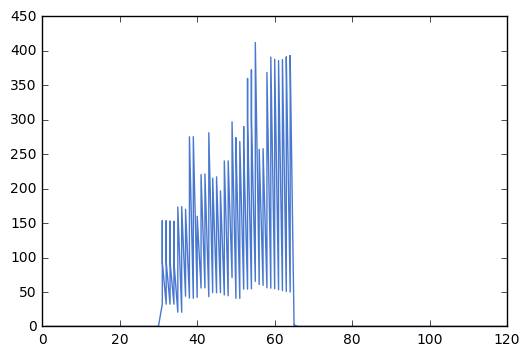

In [6]:
def get_fft(sample):
    try:
        if np.sum(np.abs(sample))<1.0: return []
        S_sample = np.abs((librosa.stft(sample)))**0.5
        return np.abs(S_sample[:,S_sample.shape[1]/2])
    except:
        return []
    
def get_fft_with_pitch_shift(sample,sr,n_steps=0):
    if np.sum(np.abs(sample))<1.0: return []
    S_sample = np.abs((librosa.stft(sample)))**0.5
    S_sample = np.abs((librosa.stft(librosa.effects.pitch_shift(sample,sr,n_steps=n_steps))))**0.5
    return np.abs(S_sample[:,S_sample.shape[1]/2])
        
        
samples['fft'] = [get_fft(sample) for sample in samples['sample']]
samples['total_sample'] = [sum(np.abs(sample)) for sample in samples['sample']]

samples['valid_sample'] = [True if len(x)>0 else False for x in samples['fft']]
plt.plot(samples['pitch'],samples['total_sample'])


samples.head()

In [7]:
def get_chord_pitches(root,majmin3='maj',majmin7='none',extensions=[]):
    
    fundamental = root%12
    fundamentals = [fundamental + x*12 for x in range(12)]
    
    all_of_them = fundamentals
    if majmin3 =='maj': all_of_them += [(fundamental+4)%12 + x*12 for x in range(12)]
    if majmin3 =='min': all_of_them += [(fundamental+3)%12 + x*12 for x in range(12)]
    all_of_them += [(fundamental+7)%12 + x*12 for x in range(12)]
    if majmin7 =='maj': all_of_them += [(fundamental+11)%12 + x*12 for x in range(12)]
    if majmin7 =='min': all_of_them += [(fundamental+10)%12 + x*12 for x in range(12)]
    for extension in extensions:
        if extension not in range(12): continue
        all_of_them += [(fundamental+extension)%12 + x*12 for x in range(12)]
        
    return sorted([num for num in all_of_them if num >= 1 and num <= 127])

def make_chord(root,samples,root_or_pitch_class='root',bank='0',vel=128,majmin3='maj',majmin7='none',extensions=[]):
    if root_or_pitch_class=='root': 
        all_notes = get_chord_pitches(root,majmin3,majmin7,extensions)
        all_notes = sorted([num for num in all_notes if num >= 40 and num <= 63])
    else: 
        all_notes = [x + 12*y for x in root for y in range(12)]
        all_notes = sorted([num for num in all_notes if num >= 40 and num <= 63])
        #print(all_notes)
    if len(all_notes)>0: pitch_class = list(frozenset([x%12 for x in all_notes]))[0]
    else: 
        pitch_class = []
        return None
    pitch_class = list(frozenset([x%12 for x in all_notes]))[0]
    weights = np.random.uniform(0.25,1,len(all_notes))
    ever_worked = False
    good_weights = []
    ever_worked = False
    for i in range(len(weights)):
        tmp = samples['fft'][(samples['bank']==bank) & (samples['vel']==vel) & (samples['pitch']==all_notes[i])]
        if len(tmp)==0: continue
        tmp = tmp.iloc[0]
        if len(tmp)==0: continue
        if not ever_worked: 
            tmp2 = tmp
            ever_worked = True
            good_weights = [weights[i]]
        else: 
            tmp2 = np.vstack((tmp2,tmp))
            good_weights.append(weights[i])
    fft = np.dot(good_weights,tmp2)
    return fft/np.sum(fft)#, sample[0]/np.max(sample[0])


def make_chord_with_pitch_shift(root,samples,sr,root_or_pitch_class='root',n_steps=0,bank='0',vel=128,majmin3='maj',majmin7='none',extensions=[]):
    if root_or_pitch_class=='root': all_notes = get_chord_pitches(root,majmin3,majmin7,extensions)
    else: 
        all_notes = [x + 12*y for x in root for y in range(12)]
        all_notes = sorted([num for num in all_notes if num >= 1 and num <= 127])
    pitch_class = list(frozenset([x%12 for x in all_notes]))[0]
    weights = np.random.uniform(0.25,1,len(all_notes))
    ever_worked = False
    for i in range(len(weights)):
        sample = samples['sample'][(samples['bank']==bank) & (samples['vel']==vel) & (samples['pitch']==all_notes[i])]
        if len(sample)==0: continue
        tmp = np.array(get_fft_with_pitch_shift(np.array(sample)[0],sr,n_steps))
        if len(tmp)==0: continue
        #tmp2 = np.array(samples['sample'][(samples['bank']==bank) & (samples['vel']==vel) & (samples['pitch']==all_notes[i])])
        if not ever_worked:
            fft = weights[i]*tmp
            ever_worked = True
            #sample = weights[i]*tmp2
        else: 
            fft += weights[i]*tmp
            #sample += weights[i]*tmp2
    if ever_worked: return fft/np.sum(fft), pitch_class#, sample[0]/np.max(sample[0])
    else: return []
    
def to1hot(row,num_categories=2):
    one_hot = np.zeros(num_categories)
    one_hot[row]=1.0
    return one_hot

def toMultiHot(pitch_bank,num_categories=12):
    output = np.zeros(num_categories)
    for i in pitch_bank:
        output[i] = 1
    return output

In [8]:
def tmp2(j):
    n_steps = 0
    chord_fft = make_chord(pitch_class,samples,root_or_pitch_class='pitch_class')
    #n_steps = np.random.uniform(-0.1,0.1,1)
    #chord_fft = make_chord_with_pitch_shift(pitch_class,samples,sr,majmin3=label_to_chord[i]['majmin3'],majmin7=label_to_chord[i]['majmin7'],n_steps=n_steps)
    tmp_dict = {'fft':chord_fft,'pitch_shift':n_steps,'pitch_class':pitch_class}
    tmp_dict.update({'repetition':j})
    return tmp_dict

num_reps = num_cores*4
ds = pd.DataFrame()
#parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps))
#print(parallel_output[0])


start = timeit.default_timer()

#zero notes
print('Doing zero-notes')
pitch_class = []
print(tmp2(0))
parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps*20))
ds = ds.append(parallel_output,ignore_index=True)

#one notes
print('Doing one-notes')
for i1 in range(12):
    print("Step %g of %g at %g percent: "%(i1,12,100*(i1)/(12.)))
    pitch_class = [i1]
    parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps*4))
    ds = ds.append(parallel_output,ignore_index=True)

print('Doing two-notes')
for i1 in range(12):
    for i2 in range(12):
        print("Step %g of %g at %g percent: "%(i1*12+i2,12*12,100*(i1*12+i2)/(12*12.)))
        pitch_class = [i1, i2]
        parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp2)(i) for i in range(num_reps*2))
        ds = ds.append(parallel_output,ignore_index=True)

stop = timeit.default_timer()

print(stop-start)


Doing zero-notes
{'pitch_shift': 0, 'repetition': 0, 'fft': None, 'pitch_class': []}
Doing one-notes
Step 0 of 12 at 0 percent: 
Step 1 of 12 at 8.33333 percent: 
Step 2 of 12 at 16.6667 percent: 
Step 3 of 12 at 25 percent: 
Step 4 of 12 at 33.3333 percent: 
Step 5 of 12 at 41.6667 percent: 
Step 6 of 12 at 50 percent: 
Step 7 of 12 at 58.3333 percent: 
Step 8 of 12 at 66.6667 percent: 
Step 9 of 12 at 75 percent: 
Step 10 of 12 at 83.3333 percent: 
Step 11 of 12 at 91.6667 percent: 
Doing two-notes
Step 0 of 144 at 0 percent: 
Step 1 of 144 at 0.694444 percent: 
Step 2 of 144 at 1.38889 percent: 
Step 3 of 144 at 2.08333 percent: 
Step 4 of 144 at 2.77778 percent: 
Step 5 of 144 at 3.47222 percent: 
Step 6 of 144 at 4.16667 percent: 
Step 7 of 144 at 4.86111 percent: 
Step 8 of 144 at 5.55556 percent: 
Step 9 of 144 at 6.25 percent: 
Step 10 of 144 at 6.94444 percent: 
Step 11 of 144 at 7.63889 percent: 
Step 12 of 144 at 8.33333 percent: 
Step 13 of 144 at 9.02778 percent: 
Step 14 

In [9]:

def tmp3(j):
    n_steps = 0
    chord_fft = make_chord(label_to_chord[i]['root'],samples,majmin3=label_to_chord[i]['majmin3'],majmin7=label_to_chord[i]['majmin7'])
    #chord_fft = make_chord_with_pitch_shift(label_to_chord[i]['root'],samples,sr,majmin3=label_to_chord[i]['majmin3'],majmin7=label_to_chord[i]['majmin7'],n_steps=n_steps)
    tmp_dict = {'fft':[chord_fft],'target':i,'pitch_shift':n_steps}
    tmp_dict.update(label_to_chord[i])
    tmp_dict.update({'repetition':j})
    return tmp_dict


            
label_to_chord = []
n = -1
set_created = False
for l in ('none', 1, 2, 3, 4, 5, 6, 8, 9, 10, 11):  #skip 7
    for k in ('none','maj','min'):
        for j in ('maj','min'):
            for i in range(12):
                if j=='maj' and l==4: continue
                if j=='maj' and l==3: continue #so we don't majmin3==maj+3 as well as majmin3==min+14
                if j=='min' and l==3: continue #leaves only majmin3==min+4
                if k=='none' and l==11: continue
                if k=='none' and l==10: continue
                if k=='maj' and l==11: continue
                if k=='maj' and l==10: continue #so we don't majmin7==maj+10 as well as majmin7==min+11
                if k=='min' and l==10: continue #leaves only majmin7==min+11
                all_notes = set([0,7])
                if j=='maj': all_notes.add(4)
                if j=='min': all_notes.add(3)
                if k=='maj': all_notes.add(11)
                if k=='min': all_notes.add(10)
                if l!='none': all_notes.add(l)
                all_notes = frozenset([(x+i)%12 for x in all_notes])
                if set_created and all_notes in set_of_all_chords: 
                    #print(all_notes)
                    continue
                if not set_created: 
                    set_of_all_chords = {all_notes}
                    set_created = True
                else: 
                    set_of_all_chords.add(all_notes)
                #k = 'none'
                n += 1
                label_to_chord.append({'root':i, 'majmin3': j, 'majmin7': k, 'extensions': l, 'pitch_class': sorted(list(all_notes))}) #it's annoying that list and ds behavior is different here
        

for i in range(len(label_to_chord)):
    print("Step %g of %g: "%(i,len(label_to_chord)) + str(label_to_chord[i]))
    if [label_to_chord[i]['extensions']=='none']: num_reps_tmp = num_reps*2
    else: num_reps_tmp = num_reps
    parallel_output = Parallel(n_jobs=num_cores)(delayed(tmp3)(i) for i in range(num_reps_tmp))
    ds = ds.append(parallel_output,ignore_index=True)
        

Step 0 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [0, 4, 7], 'root': 0, 'extensions': 'none'}
Step 1 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [1, 5, 8], 'root': 1, 'extensions': 'none'}
Step 2 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [2, 6, 9], 'root': 2, 'extensions': 'none'}
Step 3 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [3, 7, 10], 'root': 3, 'extensions': 'none'}
Step 4 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [4, 8, 11], 'root': 4, 'extensions': 'none'}
Step 5 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [0, 5, 9], 'root': 5, 'extensions': 'none'}
Step 6 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [1, 6, 10], 'root': 6, 'extensions': 'none'}
Step 7 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [2, 7, 11], 'root': 7, 'extensions': 'none'}
Step 8 of 492: {'majmin3': 'maj', 'majmin7': 'none', 'pitch_class': [0, 3, 8], 'root': 8, 'extension

In [10]:

#ds["one_hot_encoding"] = [to1hot(x,len(label_to_chord)) for x in ds['target']]
ds["multi_hot_encoding"] = [toMultiHot(x,12) for x in ds['pitch_class']]
ds.head()
ds.tail()


,extensions,fft,majmin3,majmin7,pitch_class,pitch_shift,repetition,root,target,multi_hot_encoding
42875,11,"[[0.000317645216402, 0.000330283532693, 0.0003...",min,min,"[2, 6, 9, 10, 11]",0,59,11.0,491.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
42876,11,"[[0.000232915756681, 0.000282462013064, 0.0003...",min,min,"[2, 6, 9, 10, 11]",0,60,11.0,491.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
42877,11,"[[0.000317274116683, 0.000331640555004, 0.0003...",min,min,"[2, 6, 9, 10, 11]",0,61,11.0,491.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
42878,11,"[[0.000264476459399, 0.00030275802486, 0.00031...",min,min,"[2, 6, 9, 10, 11]",0,62,11.0,491.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
42879,11,"[[0.000280290193016, 0.000305630328844, 0.0003...",min,min,"[2, 6, 9, 10, 11]",0,63,11.0,491.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [11]:
tmp = pd.DataFrame(index=range(ds.shape[0]))
tmp['harmony_pitch_class'] = None
for i in range(ds.shape[0]):
    num_pitches = np.sum(ds['multi_hot_encoding'][i])
    if num_pitches >=3:
        curr_pitches = [int((ds['root'][i])%12)]
        curr_pitches += [int((ds['root'][i]+7)%12)]
        if ds['majmin3'][i]=='maj':
            curr_pitches += [int((ds['root'][i]+4)%12)]
        else:
            curr_pitches += [int((ds['root'][i]+3)%12)]
        if ds['majmin7'][i]=='maj':
            curr_pitches += [int((ds['root'][i]+11)%12)]
        elif ds['majmin7'][i]=='min':
            curr_pitches += [int((ds['root'][i]+10)%12)]
        tmp['harmony_pitch_class'][i] = curr_pitches
    else:
        tmp['harmony_pitch_class'][i] = ds['pitch_class'][i]

tmp['multi_hot_harmony'] = [toMultiHot(x,12) for x in tmp['harmony_pitch_class']]
ds['harmony_pitch_class'] = tmp['harmony_pitch_class']
ds['multi_hot_harmony'] = tmp['multi_hot_harmony']

In [12]:
good_ind = np.where([sum(x)>0 for x in ds['multi_hot_encoding']])
#good_ind = np.where([x=='none' for x in ds['extensions']])
print(len(good_ind))
ds_sub = ds.iloc[good_ind]

#ds_sub = ds[ds['extensions']=='none']

print(ds.shape)
print(ds_sub.shape)

num_ind = ds_sub.shape[0]
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 1 - train_ratio - validation_ratio
train_ind = np.random.choice(num_ind,int(np.floor(num_ind*train_ratio)),replace=False)
rest_ind = np.setdiff1d(range(num_ind),train_ind)
validation_ind = np.random.choice(rest_ind,int(np.floor(len(rest_ind)*(validation_ratio/(validation_ratio+test_ratio)))),replace=False)
test_ind = np.setdiff1d(rest_ind,validation_ind)

train_data = ds_sub.iloc[train_ind]
validation_data = ds_sub.iloc[validation_ind]
test_data = ds_sub.iloc[test_ind]

train_data.fft.shape


1
(42880, 12)
(42240, 12)


(33792,)

In [13]:

#Gotta adjust these shape parameters
train_x = np.vstack(train_data['fft']).reshape(train_data.shape[0],len(train_data['fft'].iloc[0][0]),1,1).astype(np.float32)
train_y = np.vstack(train_data["multi_hot_harmony"])
train_size = train_y.shape[0]
validation_x = np.vstack(validation_data['fft']).reshape(validation_data.shape[0],len(validation_data['fft'].iloc[0][0]),1,1).astype(np.float32)
validation_y = np.vstack(validation_data["multi_hot_harmony"])
test_x = np.vstack(test_data['fft']).reshape(test_data.shape[0],len(validation_data['fft'].iloc[0][0]),1,1).astype(np.float32)
test_y = np.vstack(test_data["multi_hot_harmony"])

#shuffle the training_data
rand_ind = np.random.choice(train_x.shape[0],train_x.shape[0],replace=False)
train_x = train_x[rand_ind,:]
train_y = train_y[rand_ind,:]


In [14]:
BATCH_SIZE = min(train_x.shape[0],3000) # we have so little data, just set the batch size to the entire training set
NUM_CHANNELS = 1 
NUM_LABELS = train_y.shape[1]
STEP_UPDATE = 100

SEED = 27
FC1_SIZE = 512
FC2_SIZE = 256
FC3_SIZE = 128
FC4_SIZE = 64
ADAM_SIZE = 5e-5 #5e-5
REGULARIZER_SIZE = 1e-5#1e-4

MAX_STEPS = 100000
train_x.shape

(33792, 1025, 1, 1)

In [15]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, train_x.shape[1],train_x.shape[2],train_x.shape[3]],name="x-in")
true_y = tf.placeholder(tf.float32, [None, NUM_LABELS],name="y-in")
keep_prob1 = tf.placeholder("float")
keep_prob2 = tf.placeholder("float")
keep_prob3 = tf.placeholder("float")



input_length = train_x.shape[1]*train_x.shape[2]*train_x.shape[3]
input_flat = tf.reshape(inputs,[-1, input_length])

with tf.name_scope('fc1') as scope:
    weights =  tf.Variable(tf.truncated_normal([input_length, FC1_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(input_flat,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC1_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc1 = tf.nn.relu(bias, name=scope)
    keep_prob1 = tf.placeholder(tf.float32)
    fc1_drop = tf.nn.dropout(fc1, keep_prob1, name=scope)
    #fc1_drop = fc1
    
    fc1_weights = weights
    fc1_biases = biases
    
with tf.name_scope('fc2') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC1_SIZE, FC2_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc1_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC2_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc2 = tf.nn.relu(bias, name=scope)
    keep_prob2 = tf.placeholder(tf.float32)
    fc2_drop = tf.nn.dropout(fc2, keep_prob2, name=scope)
    #fc1_drop = fc1
    
    fc2_weights = weights
    fc2_biases = biases
    
with tf.name_scope('fc3') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC2_SIZE, FC3_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc2_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC3_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc3 = tf.nn.relu(bias, name=scope)
    keep_prob3 = tf.placeholder(tf.float32)
    fc3_drop = tf.nn.dropout(fc3, keep_prob3, name=scope)
    #fc1_drop = fc1
    
    fc3_weights = weights
    fc3_biases = biases
    
with tf.name_scope('fc4') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC3_SIZE, FC4_SIZE], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc3_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[FC4_SIZE]))
    bias = tf.nn.bias_add(fc, biases)
    fc4 = tf.nn.relu(bias, name=scope)
    keep_prob4 = tf.placeholder(tf.float32)
    fc4_drop = tf.nn.dropout(fc4, keep_prob3, name=scope)
    #fc1_drop = fc1
    
    fc4_weights = weights
    fc4_biases = biases
    
    
with tf.name_scope('fc5') as scope:
    weights =  tf.Variable(tf.truncated_normal([FC4_SIZE, NUM_LABELS], dtype=tf.float32, stddev=0.1, seed=SEED))
    fc = tf.matmul(fc4_drop,weights)
    biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))
    bias = tf.nn.bias_add(fc, biases)
    #fc2 = tf.nn.relu(bias, name=scope)
    fc5 = bias
    out_y = fc5
    
    fc5_weights = weights
    fc5_biases = biases
    
        
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out_y, true_y))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(out_y, true_y))

#cross_entropy = -tf.reduce_sum(true_y*tf.log(out_y))
#loss = cross_entropy

# L2 regularization for the fully connected parameters.
regularizers =  (
                tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases) +
                tf.nn.l2_loss(fc3_weights) + tf.nn.l2_loss(fc3_biases) +
                tf.nn.l2_loss(fc4_weights) + tf.nn.l2_loss(fc4_biases)
                #tf.nn.l2_loss(fc4_weights) + tf.nn.l2_loss(fc4_biases)
                #tf.nn.l2_loss(conv1_weights) + tf.nn.l2_loss(conv1_biases) +
                #tf.nn.l2_loss(conv2_weights) + tf.nn.l2_loss(conv2_biases)
)
# Add the regularization term to the loss.
loss += REGULARIZER_SIZE * (regularizers)


#For one-label
#correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#accuracy2 = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#For multi-label
#see http://stackoverflow.com/questions/37746670/tensorflow-multi-label-accuracy-calculation
correct_prediction = tf.equal(tf.round(tf.nn.sigmoid(out_y)), tf.round(true_y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#Accuracy where all labels need to be correct:
all_labels_true = tf.reduce_min(tf.cast(correct_prediction, tf.float32), 1)
accuracy2 = tf.reduce_mean(all_labels_true)




#train_step = tf.train.GradientDescentOptimizer(1e-5).minimize(loss)
train_step = tf.train.AdamOptimizer().minimize(loss)



In [16]:
def next_batch(data_size,batch_size,first_batch=False):
    global ind
    try:
        ind += 0
    except:
        first_batch = True
    
    if first_batch == True or batch_size != len(ind):
        ind = np.mod(range(batch_size),data_size)
        return ind
    
    ind += batch_size
    ind %= data_size
    return ind

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
batch_size = BATCH_SIZE
layer_diagnostics = pd.DataFrame(columns=('step','layer',
                                          'weight','weight_grad','bias','bias_grad'#,
                                          #'weight_norm','weight_grad_norm','bias_norm','bias_grad_norm'
                                         ))


start = timeit.default_timer()


for i in range(MAX_STEPS+1):
    ind = next_batch(train_x.shape[0],batch_size)
    batch_x = train_x[ind]
    batch_y = train_y[ind]
    if i > 0: 
        if i<2: train_start = timeit.default_timer()
        sess.run(train_step, feed_dict={inputs:batch_x,true_y:batch_y, keep_prob1:0.5, keep_prob2:0.5, keep_prob3:0.5})
        if i<2: train_stop = timeit.default_timer()
        if i<2: print("Training time for 1000 steps: %g"%(1000*(train_stop-train_start)))
    if i < 2 or ( i % STEP_UPDATE == 0 and i != 0 ) :
        
        fc1_weights_val, fc1_weights_grad_val,\
        fc1_biases_val, fc1_biases_grad_val,\
        fc2_weights_val, fc2_weights_grad_val,\
        fc2_biases_val, fc2_biases_grad_val,\
        fc3_weights_val, fc3_weights_grad_val,\
        fc3_biases_val, fc3_biases_grad_val,\
        fc4_weights_val, fc4_weights_grad_val,\
        fc4_biases_val, fc4_biases_grad_val,\
        fc5_weights_val, fc5_weights_grad_val,\
        fc5_biases_val, fc5_biases_grad_val,\
        out_y_val, out_y_grad_val,\
        trainAccuracy, trainAccuracy2, trainLoss =\
            sess.run([
                fc1_weights, tf.gradients(loss,fc1_weights)[0],
                fc1_biases, tf.gradients(loss,fc1_biases)[0],
                fc2_weights, tf.gradients(loss,fc2_weights)[0],
                fc2_biases, tf.gradients(loss,fc2_biases)[0],
                fc3_weights, tf.gradients(loss,fc3_weights)[0],
                fc3_biases, tf.gradients(loss,fc3_biases)[0],
                fc4_weights, tf.gradients(loss,fc4_weights)[0],
                fc4_biases, tf.gradients(loss,fc4_biases)[0],
                fc5_weights, tf.gradients(loss,fc5_weights)[0],
                fc5_biases, tf.gradients(loss,fc5_biases)[0],
                out_y, tf.gradients(loss,out_y)[0],
                accuracy, accuracy2, loss
            ],
                                feed_dict={
                                    inputs:batch_x,
                                    true_y:batch_y,
                                    keep_prob1:1.0,
                                    keep_prob2:1.0,
                                    keep_prob3:1.0,
                                    keep_prob4:1.0})
        
        #validationAccuracy = sess.run(accuracy, 
        #                        feed_dict={
        #                            inputs:validation_x,
        #                            true_y:validation_y, 
        #                            keep_prob:1.0})
        
        fc1_norm = np.linalg.norm(fc1_weights_val)
        fc1_grad_norm = np.linalg.norm(fc1_weights_val)
        fc1_bias_norm = np.linalg.norm(fc1_biases_val)
        fc1_bias_grad_norm = np.linalg.norm(fc1_biases_val)
        fc2_norm = np.linalg.norm(fc2_weights_val)
        fc2_grad_norm = np.linalg.norm(fc2_weights_val)
        fc2_bias_norm = np.linalg.norm(fc2_biases_val)
        fc2_bias_grad_norm = np.linalg.norm(fc2_biases_val)
        fc3_norm = np.linalg.norm(fc3_weights_val)
        fc3_grad_norm = np.linalg.norm(fc3_weights_val)
        fc3_bias_norm = np.linalg.norm(fc3_biases_val)
        fc3_bias_grad_norm = np.linalg.norm(fc3_biases_val)
        fc4_norm = np.linalg.norm(fc4_weights_val)
        fc4_grad_norm = np.linalg.norm(fc4_weights_val)
        fc4_bias_norm = np.linalg.norm(fc4_biases_val)
        fc4_bias_grad_norm = np.linalg.norm(fc4_biases_val)
        fc5_norm = np.linalg.norm(fc5_weights_val)
        fc5_grad_norm = np.linalg.norm(fc5_weights_val)
        fc5_bias_norm = np.linalg.norm(fc5_biases_val)
        fc5_bias_grad_norm = np.linalg.norm(fc5_biases_val)
        out_y_norm = np.linalg.norm(out_y_val)
        out_y_grad_norm = np.linalg.norm(out_y_grad_val)
        
        
        layer_diagnostics.append({
                'step':i,
                'layer':'fc1',
                'weight_norm':fc1_norm,
                'weight_grad_norm':fc1_grad_norm,
                'bias_norm':fc1_bias_norm,
                'bias_grad_norm':fc1_bias_grad_norm},ignore_index=True)
        layer_diagnostics.append({
                'step':i,
                'layer':'fc2',
                'weight_norm':fc2_norm,
                'weight_grad_norm':fc2_grad_norm,
                'bias_norm':fc2_bias_norm,
                'bias_grad_norm':fc2_bias_grad_norm},ignore_index=True)
        layer_diagnostics.append({
                'step':i,
                'layer':'fc3',
                'weight_norm':fc3_norm,
                'weight_grad_norm':fc3_grad_norm,
                'bias_norm':fc3_bias_norm,
                'bias_grad_norm':fc3_bias_grad_norm},ignore_index=True)
        layer_diagnostics.append({
                'step':i,
                'layer':'fc4',
                'weight_norm':fc4_norm,
                'weight_grad_norm':fc4_grad_norm,
                'bias_norm':fc4_bias_norm,
                'bias_grad_norm':fc4_bias_grad_norm},ignore_index=True)
        layer_diagnostics.append({
                'step':i,
                'layer':'fc5',
                'weight_norm':fc5_norm,
                'weight_grad_norm':fc5_grad_norm,
                'bias_norm':fc5_bias_norm,
                'bias_grad_norm':fc5_bias_grad_norm},ignore_index=True)
        layer_diagnostics.append({
                'step':i,
                'layer':'out_y',
                'weight_norm':out_y_norm,
                'weight_grad_norm':out_y_grad_norm,
                'bias_norm':0,
                'bias_grad_norm':0},ignore_index=True)
                
        validationAccuracy, validationAccuracy2 = sess.run([accuracy, accuracy2], 
                            feed_dict={
                                inputs:validation_x,
                                true_y:validation_y,
                                    keep_prob1:1.0,
                                    keep_prob2:1.0,
                                    keep_prob3:1.0,
                                    keep_prob4:1.0})
            
                
        stop = timeit.default_timer()

        if i==0: print("Initialization:")
        else: print("Step %d:"%(i))
        print("    fc1 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
              (fc1_norm, fc1_grad_norm, fc1_bias_norm, fc1_bias_grad_norm))
        print("    fc2 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
              (fc2_norm, fc2_grad_norm, fc2_bias_norm, fc2_bias_grad_norm))
        print("    fc3 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
              (fc3_norm, fc3_grad_norm, fc3_bias_norm, fc3_bias_grad_norm))
        print("    fc4 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
              (fc4_norm, fc4_grad_norm, fc4_bias_norm, fc4_bias_grad_norm))
        print("    fc5 norm   %g, grad norm %g, bias norm %g, bias grad norm %g"%
              (fc5_norm, fc5_grad_norm, fc5_bias_norm, fc5_bias_grad_norm))
        print("    out_y_norm %g, grad norm %g"%(out_y_norm, out_y_grad_norm))
        print("    training accuracy %g, valid'n accuracy %g, loss %g"%(trainAccuracy, validationAccuracy,trainLoss))
        print("    training accuracy2 %g, valid'n accuracy2 %g"%(trainAccuracy2, validationAccuracy2))
        #print("    percent training samples classified as not zero %g"%(100.0*float(np.sum((np.argmax(out_y_val,1))))/float(out_y_val.shape[0])))
        if i>0: print("    seconds since start %g, ETA(s) %g"%((stop-start),(stop-start)*float(MAX_STEPS-i)/float(i)))
            
        
        if trainAccuracy2>0.99:
            print('Success! Shall stop training now although I could go further to improve loss function')
            break
            

Initialization:
    fc1 norm   63.7157, grad norm 63.7157, bias norm 2.26274, bias grad norm 2.26274
    fc2 norm   31.9248, grad norm 31.9248, bias norm 1.6, bias grad norm 1.6
    fc3 norm   15.9852, grad norm 15.9852, bias norm 1.13137, bias grad norm 1.13137
    fc4 norm   7.88883, grad norm 7.88883, bias norm 0.8, bias grad norm 0.8
    fc5 norm   2.29394, grad norm 2.29394, bias norm 0.34641, bias grad norm 0.34641
    out_y_norm 22.3004, grad norm 0.00269108
    training accuracy 0.305472, valid'n accuracy 0.302971, loss 0.741645
    training accuracy2 0, valid'n accuracy2 0
Training time for 1000 steps: 199.008
Step 1:
    fc1 norm   63.474, grad norm 63.474, bias norm 2.25976, bias grad norm 2.25976
    fc2 norm   31.9193, grad norm 31.9193, bias norm 1.59734, bias grad norm 1.59734
    fc3 norm   15.982, grad norm 15.982, bias norm 1.129, bias grad norm 1.129
    fc4 norm   7.88665, grad norm 7.88665, bias norm 0.799033, bias grad norm 0.799033
    fc5 norm   2.29413, grad no

KeyboardInterrupt: 

In [18]:

#I want to get indices of train_x that are correctly, and incorrectly identified
tmp1, tmp2 = sess.run([tf.nn.sigmoid(out_y), true_y], 
                            feed_dict={
                                inputs:validation_x,
                                true_y:validation_y, 
                                keep_prob1:1.0,keep_prob2:1.0,keep_prob3:1.0})

print("Correct Predictions:")
for i in np.where(np.sum(np.abs(np.round(tmp1)-tmp2),1)==0)[0]:
    0
    #print('Guess vector: '+str(tmp1[i,:]))
    #print('Guess: '+str(np.where(np.round(tmp1[i,:])==1)))
    #tmp = np.power(validation_data['fft'].iloc[i],2.0)
    #tmp = librosa.istft(np.repeat(tmp.reshape([len(tmp),1]),10,axis=1))
    #IPython.display.display(IPython.display.Audio(data=tmp, rate=sr))
print("")    
    
print("Incorrect Predictions:")
for i in np.where(np.sum(np.abs(np.round(tmp1)-tmp2),1)!=0)[0]:
    print(i)
    #print('Guess vector: '+str(tmp1[i,:]))
    print('Guess: '+str(np.where(np.round(tmp1[i,:])==1))+' Reality: '+str(np.where(tmp2[i,:]==1)))
    #tmp = np.power(validation_data['fft'].iloc[i],2.0)
    #tmp = librosa.istft(np.repeat(tmp.reshape([len(tmp),1]),10,axis=1))
    #IPython.display.display(IPython.display.Audio(data=tmp, rate=sr))
print("")    

Correct Predictions:

Incorrect Predictions:



In [22]:
#audio_path = librosa.util.example_audio_file()

emaj, sr = librosa.load('emaj.aiff')
amaj, sr = librosa.load('amaj.aiff')

emaj_fft = get_fft(emaj)
qmaj_fft = get_fft(librosa.effects.pitch_shift(emaj,sr,n_steps=1))
amaj_fft = get_fft(amaj)
emaj_fft = emaj_fft/np.sum(emaj_fft)
qmaj_fft = qmaj_fft/np.sum(qmaj_fft)
amaj_fft = amaj_fft/np.sum(amaj_fft)

rwds = pd.DataFrame() #real-world dataset

#http://www.electronics.dit.ie/staff/tscarff/Music_technology/midi/midi_note_numbers_for_octaves.htm
emaj_dict = {'root':4,'majmin3':'maj','majmin7':'none','pitch_class':[4, 8, 11]}
#emaj_dict.update({'target':label_to_chord.index(emaj_dict)})
emaj_dict.update({'fft':emaj_fft})
qmaj_dict = {'root':5,'majmin3':'maj','majmin7':'none','pitch_class':[0, 5, 9]}
#qmaj_dict.update({'target':label_to_chord.index(qmaj_dict)})
qmaj_dict.update({'fft':qmaj_fft})
amaj_dict = {'root':9,'majmin3':'maj','majmin7':'none','pitch_class':[1, 4, 9]}
#amaj_dict.update({'target':label_to_chord.index(amaj_dict)})
amaj_dict.update({'fft':amaj_fft})



rwds = rwds.append(emaj_dict,ignore_index=True)
rwds = rwds.append(qmaj_dict,ignore_index=True)
rwds = rwds.append(amaj_dict,ignore_index=True)

#rwds["one_hot_encoding"] = [to1hot(x,len(label_to_chord)) for x in rwds['target']]
rwds["multi_hot_encoding"] = [toMultiHot(x,12) for x in rwds['pitch_class']]



realworld_x = np.vstack(rwds['fft']).reshape(rwds.shape[0],rwds['fft'].iloc[0].shape[0],1,1).astype(np.float32)
#realworld_y = np.vstack(rwds["one_hot_encoding"])
realworld_y = np.vstack(rwds["multi_hot_encoding"])


tmp1, tmp2 = sess.run([tf.nn.sigmoid(out_y), true_y], 
                            feed_dict={
                                inputs:realworld_x,
                                true_y:realworld_y, 
                                keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0})

for i in range(tmp1.shape[0]):
    #print('Guess vector: '+str(tmp1[i,:]))
    print('Guess: '+str(np.where(np.round(tmp1[i,:])==1))+' Reality: '+str(np.where(tmp2[i,:]==1)))

Guess: (array([ 4,  8, 11]),) Reality: (array([ 4,  8, 11]),)
Guess: (array([0, 5]),) Reality: (array([0, 5, 9]),)
Guess: (array([1, 4, 9]),) Reality: (array([1, 4, 9]),)


In [ ]:
#any_song_file is originally an mp3 on my hard drive of The Beatles' "Something"
#I can't upload that, but you can substitute any song of your choosing
something, something_sr = librosa.load(any_song_file)

something_harmonic, something_percussive = librosa.effects.hpss(something)
print(something_sr)

In [ ]:
def extract_fft(sample):
    try:
        S_sample = np.abs((librosa.stft(sample)))**0.5
        return S_sample[:,range(0,S_sample.shape[1],9)]
    except:
        return []
    
tmp = extract_fft(something)
print(tmp.shape)
print(len(something)/something_sr/60.)
print(7881./(float(len(something))/float(something_sr))/5.)
print(round(float(len(something))/7881.*4))
print('Samples per sec: %g'%(876/3.03/60))

In [ ]:
something_x = extract_fft(something_harmonic).transpose()
something_x = something_x.reshape([something_x.shape[0], something_x.shape[1], 1, 1])
something_x.shape

#I want to get indices of train_x that are correctly, and incorrectly identified
tmp1 = sess.run(tf.round(tf.nn.sigmoid(out_y)), 
                            feed_dict={
                                inputs:something_x,
                                #true_y:validation_y, 
                                keep_prob1:1.0,keep_prob2:1.0,keep_prob3:1.0})



print("Predictions:")
for i in range(tmp1.shape[0]):
    print(np.where(tmp1[i,:]==1))
